In [1]:
from scipy.optimize import curve_fit, fmin
from scipy.misc import imread
import numpy as np
import csv
import numpy.polynomial.polynomial as poly
import sys, os
from functools import partial
from sklearn import linear_model
import pylab as plt
%matplotlib inline

PIXEL_WIDTH = 5.2*10**-3
# Generate a 2d gaussian on the provided x-y grid
def two_dim_gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x,y) = xdata_tuple
    # Make sure the grid values are floats.
    xo = float(xo)
    yo = float(yo)
    # NB: if adapting for python 2.x (x>=2), always remember to:
    # from __future__ import division
    # otherwise, the below divisions will be of the floor variety -
    # output will always be integers.
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

In [2]:
def compute_curve_fit(path):
    #the flatten keyword argument refers to the value
    #at each pixel - we want a 2d array, rather than
    # a 3d one (in which the third axis is for the rgb components).
    im = imread(path, flatten=True)
    h = len(im)
    w = len(im[0])
    # enforce treatment of im as an n-D array of floats, and return a flattened copy.
    p = np.asarray(im).astype('float').ravel()
    # Find the maximum value of p, scale p by that value.
    # Feature scaling, not trad. normalization.
    max_val = np.amax(p)
    p = p / max_val
    # Construct background grid - curve_fit wants an n-D space to map p onto.
    x = np.linspace(0, w, w)
    y = np.linspace(0, h, h)
    x, y = np.meshgrid(x, y)
    xy = (x,y)
    # Plot configuration
    plt.figure()
    plt.imshow(p.reshape(h, w))
    plt.colorbar()
    # Initial guess to feed curve_fit. If an optimization run doesn't converge,
    # and you know it should, pick a different value (100.jpg had this issue).
    print(1./np.std(p))
    initial_guess = (50,100,100,40,40,0,10)
    popt, pcov = curve_fit(two_dim_gaussian, xdata=xy,ydata=p, p0=initial_guess)
    print(popt)
    # pull out values from curve_fit's optimization array ret-val.
    # NB: this matches the arguments of the func provided to curve_fit, excluding
    # the first arg (input data)
    amp,x0,y0,std_x,std_y = popt[0:5]
    print("Amplitude = {}".format(amp))
    # Adapted from expression for FWHM in terms of stdev.
    # See next cell for derivation.
    width = np.mean([abs(std_x), abs(std_y)])*2*np.sqrt(2)
    print("Width = {}".format(width))
    print("Centre = {},{}".format(x0,y0))
    print("Background = {}".format(popt[-1]))
    # Generate the gaussian from the optimization parameter output.
    data_fitted = two_dim_gaussian((x, y), *popt)
    fig, ax = plt.subplots(1, 1)
    ax.imshow(data_fitted.reshape(h, w), cmap=plt.cm.jet, origin='lower',
        extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(x, y, data_fitted.reshape(h, w), 8, colors='w')
    plt.show()
    return width

\begin{equation*}
\text{Find } x_0 \text{, where } x_0 = \dfrac{1}{e}f(x_{max}) \\
f(x) = \dfrac{1}{\sigma \sqrt{2\pi}}e^{\dfrac{-(x-\mu)^2}{2\sigma^2}} \\
\text{Ignore the constant scaling factor, and solve for } x_0 \\
e^{\dfrac{-(x_0-\mu)^2}{2\sigma^2}} = \dfrac{1}{e}f(x_{max}) \\
\text{Since } f(x_{max}) \text{ occurs at } \mu \text{, which resolves to } e^0 \\
e^{\dfrac{-(x_0-\mu)^2}{2\sigma^2}} = \dfrac{1}{e} \\
\dfrac{-(x_0-\mu)^2}{2\sigma^2} = -ln(e) \\
(x_0-\mu)^2=2\sigma^2 \\
x_0 = \pm\sigma\sqrt{2} + \mu \\
\text{Full width at } e^{-1}f(x_{max}) = x_{max} - x_{min} = 2\sigma \sqrt{2} \\
\text{Similarly, for the metric chosen by the manufacturer,} \\
\text{Full width at } e^{-2} = 4\sigma 
\end{equation*}

100.jpg
8.81058830776
[  9.11272754e-01   1.59244744e+02   7.22888262e+01   1.96982347e+01
   2.01535345e+01   3.25944110e+03   8.88211085e-03]
Amplitude = 0.911272754359464
Width = 56.35891247166752
Centre = 159.24474407487367,72.28882622676817
Background = 0.008882110851405271


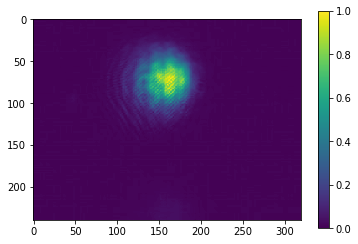

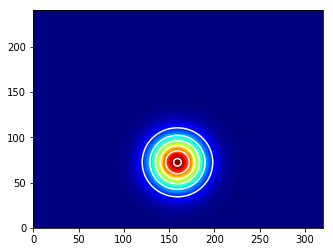

200_repeat.jpg
10.4891499766
[  7.48080456e-01   1.62388050e+02   9.06681746e+01  -2.04135037e+01
   2.00891342e+01   3.13934458e+02   1.21196521e-02]
Amplitude = 0.748080455503674
Width = 57.279379765377215
Centre = 162.38804963627618,90.66817462574984
Background = 0.012119652087116496


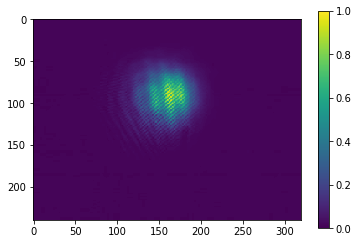

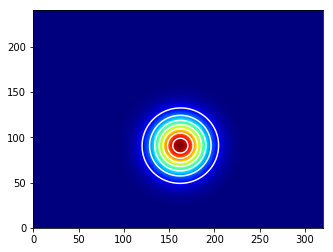

200.jpg
10.646869245
[  7.36404719e-01   1.27343479e+02   8.31529357e+01   2.04718408e+01
   2.04178413e+01   1.71578869e+02   6.42749335e-03]
Amplitude = 0.7364047188233804
Width = 57.82674305535485
Centre = 127.34347921202236,83.15293567086255
Background = 0.006427493348494415


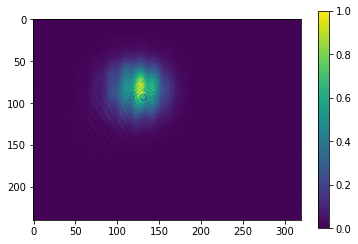

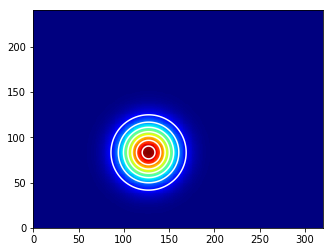

300.jpg
10.3662961767
[  7.31905356e-01   1.13924802e+02   7.46689741e+01   2.12923484e+01
   2.10679017e+01  -1.14571526e+02   1.27427228e-02]
Amplitude = 0.7319053562856116
Width = 59.90644020222721
Centre = 113.92480246378739,74.66897405393107
Background = 0.012742722752626948


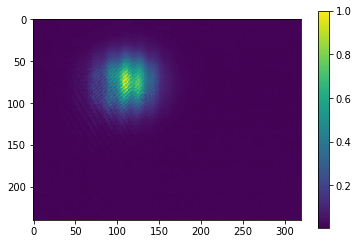

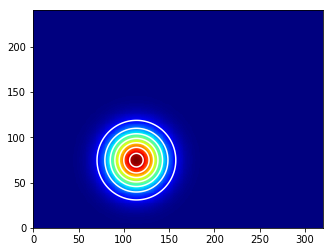

400.jpg
9.73493649892
[  7.41540189e-01   1.25524906e+02   7.82792937e+01   2.23392971e+01
   2.23538268e+01   4.58201778e+02   1.02168923e-02]
Amplitude = 0.7415401885162142
Width = 63.20562205194365
Centre = 125.52490598035466,78.27929366484379
Background = 0.010216892288656099


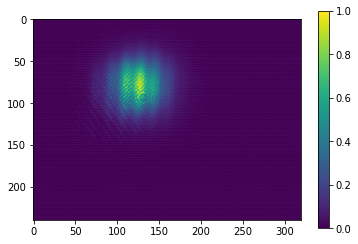

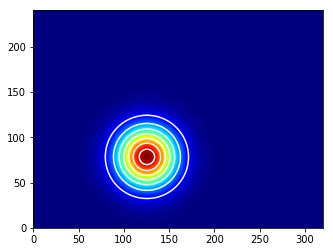

500_repeat.jpg
8.4532512874
[  8.70684040e-01   1.29927853e+02   9.01023463e+01   2.18593655e+01
   2.22781984e+01   4.72583608e+01   1.07215087e-02]
Amplitude = 0.870684039589295
Width = 62.41994150363684
Centre = 129.9278533202405,90.10234632326251
Background = 0.01072150868723491


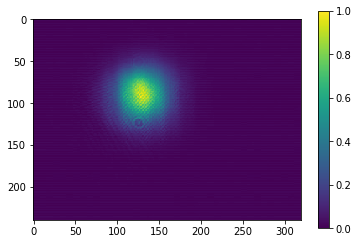

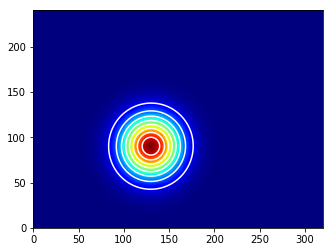

500.jpg
9.37778320362
[  7.30525691e-01   1.13157228e+02   7.88452550e+01   2.35622131e+01
   2.38624468e+01  -1.42498502e+02   1.37193711e-02]
Amplitude = 0.7305256910736794
Width = 67.06859729368067
Centre = 113.1572280377181,78.84525499733454
Background = 0.013719371087458326


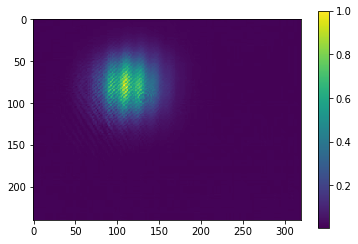

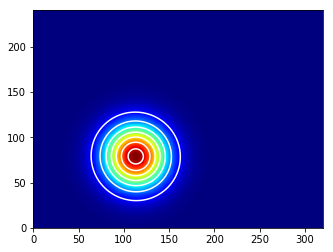

600.jpg
9.13402395209
[  7.60436991e-01   1.07127723e+02   7.91143146e+01   2.32569248e+01
   2.36538947e+01  -4.41968269e+01   1.11557488e-02]
Amplitude = 0.7604369905255555
Width = 66.34191710301545
Centre = 107.12772347700752,79.1143145582787
Background = 0.01115574879281886


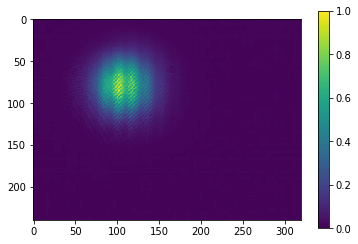

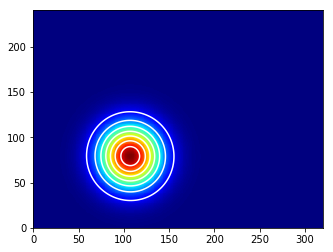

800.jpg
8.52943605826
[  7.34423650e-01   1.18886487e+02   1.09060228e+02   2.60008515e+01
   2.64602998e+01  -5.67050520e+01   1.26291084e-02]
Amplitude = 0.7344236500146181
Width = 74.19127163504986
Centre = 118.88648673648821,109.06022798641057
Background = 0.012629108383537882


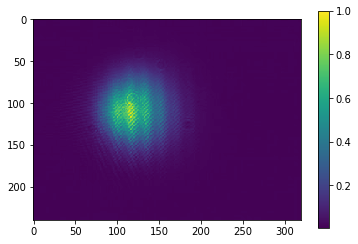

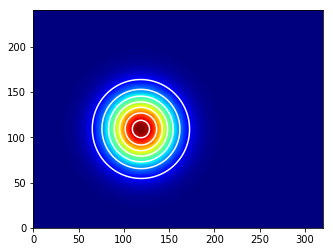

1000.jpg
7.62361657477
[  7.34178172e-01   1.14284186e+02   1.28370284e+02   2.98134978e+01
   2.96044411e+01   7.62597582e+01   9.45797469e-03]
Amplitude = 0.7341781716882563
Width = 84.02965496972189
Centre = 114.28418567673542,128.3702836684075
Background = 0.009457974692903257


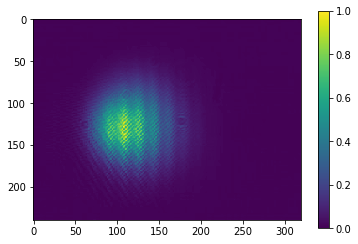

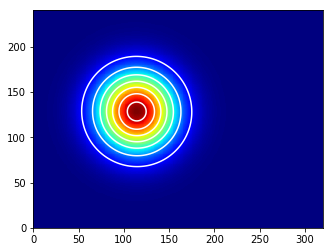

1200.jpg
6.78670065145
[  7.53423269e-01   9.22135477e+01   9.90069369e+01   3.39264329e+01
   3.30372845e+01   6.68045739e+00   1.97464194e-02]
Amplitude = 0.753423268681465
Width = 94.70099736020856
Centre = 92.21354770954954,99.0069369181563
Background = 0.019746419383102603


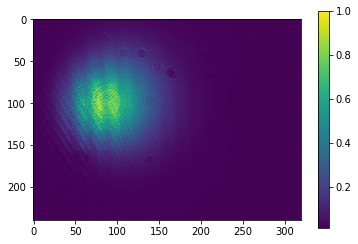

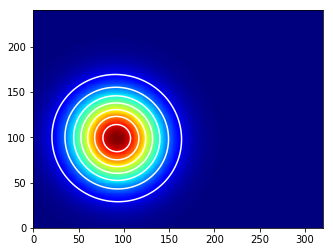

1400.jpg
6.0347924601
[  7.77937452e-01   9.50052439e+01   9.43958017e+01   3.77480171e+01
   3.69145528e+01  -2.16128073e+01   1.55044485e-02]
Amplitude = 0.7779374519398456
Width = 105.58881897130858
Centre = 95.0052438562361,94.39580165113368
Background = 0.015504448491378067


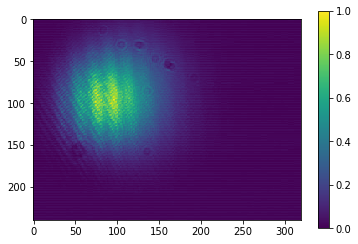

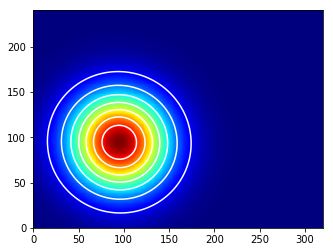

1400_repeat.jpg
6.4054911409
[  7.39984817e-01   1.37627673e+02   1.08309607e+02   3.60893133e+01
   3.71119512e+01  -2.82576905e+01   2.10420417e-02]
Amplitude = 0.7399848166494306
Width = 103.52222102621377
Centre = 137.62767274651878,108.3096071850566
Background = 0.02104204173236406


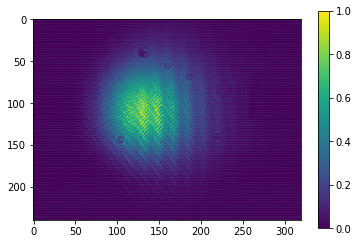

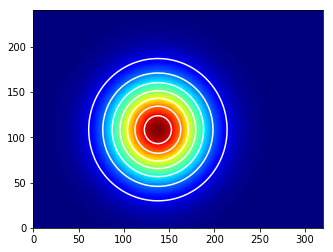

In [3]:
# filter out non-jpgs, and sort by numeric rather than alphanumeric order
sort_condition = lambda k: int(k.split(".jpg")[0].split("_")[0])
root_dir = "/home/nicholas/Downloads/OPT1"
z_beam_width_pairs = []
# Loop through files in root_dir that satisfy sort_condition,
# run curve fitting routine
dir_iterator = filter(lambda v: v.endswith('.jpg'), os.listdir(root_dir))
for img in sorted(dir_iterator, key=sort_condition):
    print(img)
    width_px = compute_curve_fit(os.path.join("/home/nicholas/Downloads/OPT1", img))
    z_beam_width_pairs.append((sort_condition(img), (width_px*PIXEL_WIDTH)))

100
0.293066344853
[ 0.0855217   0.10705158]
[ 0.00030151]
2
[ 1.29300963  0.57282293]
2.88657986403e-15


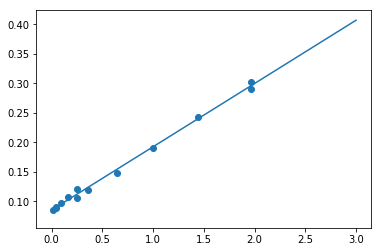

In [14]:
z,widths = zip(*z_beam_width_pairs)
# z = list(map(lambda v: v**2, z))
print(z[0])
# widths = list(map(lambda v: v**2, widths))
print(widths[0])
with open("beam_profile_data.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['z (mm)', 'beam_width (mm)'])
    for pair in z_beam_width_pairs:
        writer.writerow(pair)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
# 
widths = list(map(lambda w: (w)**2, widths))
# Express z in meters
z = list(map(lambda z: (z/1000)**2, z))
ax1.scatter(z,widths)
p, [res, rank, singular_values, rcond] = poly.polyfit(z,widths,1, full=True)
print(p)
print(res)
print(rank)
print(singular_values)
print(rcond)
xp = np.linspace(0, 3,100)
ffit = poly.polyval(xp, p)
ax1.plot(xp, ffit)
plt.show()